# A day with *(the)* Julia *(language)*  

## Análisis de datos   
   

In [1]:
ENV["LINES"]   = 10 
ENV["COLUMNS"] = 60;

- *DataFrame* para manejar datos tabulares, datos faltantes...
- *Gadfly* para hacer rápidamente gráficos estadísticos al estilo de *ggplot2* 
- *Plots* para graficar independiente del *backend*, soporte para animaciones, gráficos interactivos con *Plotly* o 3D, etc.
- *IJulia* para trabajar con IPython/**Ju**pyter notebooks, e *Interact*
- Test estadísticos, clustering, etc. con los paquetes de la organización [**JuliaStats**](http://juliastats.github.io/)

In [2]:
using DataFrames
benchmark = readtable(joinpath("data","benchmark.csv"), separator=';')

,Benchmark,Fortran,Julia,Python,R,Matlab,Octave,Mathematica,JavaScript,Go,LuaJIT,Java
1,fib,0.7,2.11,77.76,533.52,26.89,9324.35,118.53,3.36,1.86,1.71,1.21
2,parse_int,5.05,1.45,17.02,45.73,802.52,9581.44,15.02,6.06,1.2,5.77,3.35
3,quicksort,1.31,1.15,32.89,264.54,4.92,1866.01,43.23,2.7,1.29,2.03,2.6
4,mandel,0.81,0.79,15.32,53.16,7.58,451.81,5.13,0.66,1.11,0.67,1.35
5,pi_sum,1.0,1.0,21.99,9.56,1.0,299.31,1.69,1.01,1.0,1.0,1.0
6,rand_mat_stat,1.45,1.66,17.93,14.56,14.52,30.93,5.95,2.3,2.96,3.27,3.92
7,rand_mat_mul,3.48,1.02,1.14,1.57,1.12,1.12,1.3,15.07,1.42,1.16,2.36


In [3]:
longformat = melt(benchmark, [:Benchmark]) # Reshaping: wide -> long

,variable,value,Benchmark
1,Fortran,0.7,fib
2,Fortran,5.05,parse_int
3,Fortran,1.31,quicksort
4,Fortran,0.81,mandel
5,Fortran,1.0,pi_sum
6,Fortran,1.45,rand_mat_stat
7,Fortran,3.48,rand_mat_mul
8,Julia,2.11,fib
9,Julia,1.45,parse_int
10,Julia,1.15,quicksort


In [4]:
meantime = by(longformat, :variable, df -> mean( df[:value] )) # Split-Apply-Combine

,variable,x1
1,Fortran,1.9714285714285715
2,Go,1.5485714285714285
3,Java,2.255714285714286
4,JavaScript,4.451428571428571
5,Julia,1.3114285714285712
6,LuaJIT,2.23
7,Mathematica,27.264285714285712
8,Matlab,122.64999999999999
9,Octave,3079.281428571429
10,Python,26.292857142857144


In [5]:
sort!(meantime, cols=[:x1]) # Sorting
names!(meantime, [:Lenguaje, :Tiempo_Medio])

,Lenguaje,Tiempo_Medio
1,Julia,1.3114285714285712
2,Go,1.5485714285714285
3,Fortran,1.9714285714285715
4,LuaJIT,2.23
5,Java,2.255714285714286
6,JavaScript,4.451428571428571
7,Python,26.292857142857144
8,Mathematica,27.264285714285712
9,Matlab,122.64999999999999
10,R,131.80571428571426


Descripción (estadística) del dataset (columnas), similar a `summary` de *R*.

In [6]:
describe(meantime)

Lenguaje
Length  11
Type    Symbol
NAs     0
NA%     0.0%
Unique  11

Tiempo_Medio
Min      1.3114285714285712
1st Qu.  2.100714285714286
Median   4.451428571428571
Mean     309.1875324675325
3rd Qu.  74.95714285714286
Max      3079.281428571429
NAs      0
NA%      0.0%



### Usando funciones de R

In [8]:
using RCall

In [9]:
ks = R"""ks.test($(benchmark[:Julia]), $(benchmark[:R]))"""

RCall.RObject{RCall.VecSxp}

	Two-sample Kolmogorov-Smirnov test

data:  `#JL`$`(benchmark[:Julia])` and `#JL`$`(benchmark[:R])`
D = 0.85714, p-value = 0.008159
alternative hypothesis: two-sided



In [10]:
rcopy(ks) # Transforma los datos de R a tipos de datos de Julia

Dict{Symbol,Any} with 5 entries:
  :statistic          => 0.857143
  :alternative        => "two-sided"
  Symbol("p.value")   => 0.00815851
  :method             => "Two-sample Kolmogorov-Smirnov tes…
  Symbol("data.name") => "`#JL`\$`(benchmark[:Julia])` and …

### JuliaStats

Muchos de los tests estadísticos más clásicos están definidos en alguna biblioteca de Julia

In [12]:
using HypothesisTests

In [13]:
ApproximateTwoSampleKSTest(benchmark[:Julia], benchmark[:R])

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.857142857142857

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.011681952358448919

Details:
    number of observations:   [7,7]
    KS-statistic:              1.603567451474546


In [14]:
SignedRankTest(
convert(Vector{Float64}, benchmark[:Julia]), 
convert(Vector{Float64}, benchmark[:R])
) # Wilcoxon signed rank test

Exact Wilcoxon signed rank test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -44.279999999999994
    95% confidence interval: (-291.89,-6.7250000000000005)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.015625000000000003

Details:
    number of observations:      7
    Wilcoxon rank-sum statistic: 0.0
    rank sums:                   [0.0,28.0]
    adjustment for ties:         0.0


In [16]:
using GLM

lineal = lm(@formula(R ~ Julia), benchmark)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: R ~ 1 + Julia

Coefficients:
             Estimate Std.Error t value Pr(>|t|)
(Intercept)  -247.159   200.519 -1.2326   0.2725
Julia         288.971   145.487 1.98623   0.1037


In [17]:
inter, pend = coef(lineal)

2-element Array{Float64,1}:
 -247.159
  288.971

In [22]:
using Plots, StatPlots


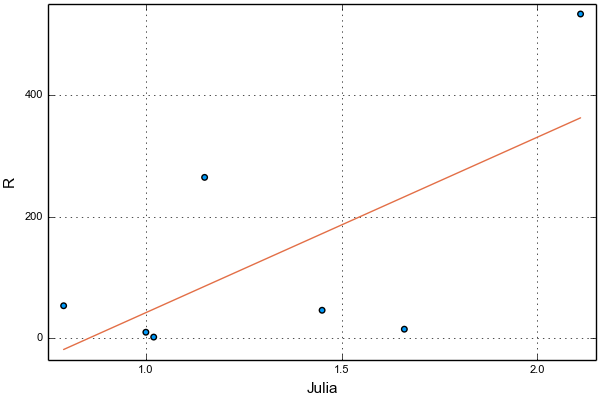

In [24]:
scatter(benchmark[:Julia], benchmark[:R], legend=false, xlab="Julia", ylab="R")
Plots.abline!(pend, inter)

In [25]:
using Distributions

β = rand(Beta(2,2), 1000)

1000-element Array{Float64,1}:
 0.326723
 0.327877
 0.615056
 ⋮       
 0.787692
 0.636218

### Usando bibliotecas de R

In [27]:
# R"""
# install.packages("modeest")
# """

@rimport modeest as rmode

β_mode = rmode.hsm(β) # half-sample mode


This is package 'modeest' written by P. PONCET.
For a complete list of functions, use 'library(help = "modeest")' or 'help.start()'.



RCall.RObject{RCall.RealSxp}
[1] 0.5082594


In [28]:
rcopy(β_mode)

0.5082594499045219

## Clustering

In [29]:
iris = readtable(joinpath("data", "iris.csv"))

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa
10,4.9,3.1,1.5,0.1,setosa


In [31]:
using Clustering

cl = kmeans(convert(Matrix{Float64}, iris[:, [:PetalWidth, :PetalLength]])', 3)

Clustering.KmeansResult{Float64}([1.35926 0.246 2.04783; 4.29259 1.462 5.62609],[2,2,2,2,2,2,2,2,2,2  …  3,3,3,3,3,3,3,3,3,3],[0.00596,0.00596,0.02836,0.00356,0.00596,0.08036,0.00676,0.00356,0.00596,0.02276  …  0.124707,0.340359,0.29862,0.13862,0.209924,0.245142,0.413837,0.183837,0.114707,0.338185],[54,50,46],[54.0,50.0,46.0],31.412885668276868,5,true)

In [32]:
cl.centers'

3×2 Array{Float64,2}:
 1.35926  4.29259
 0.246    1.462  
 2.04783  5.62609

In [33]:
by(iris, :Species, df -> (mean(df[:PetalWidth]), mean(df[:PetalLength])))

,Species,x1
1,setosa,"(0.24600000000000002,1.462)"
2,versicolor,"(1.3259999999999998,4.260000000000001)"
3,virginica,"(2.026,5.5520000000000005)"
